In [78]:
import sys
import os
top_path = os.path.abspath("../")
if top_path not in sys.path:
    sys.path.insert(0, top_path)

import astropy.coordinates as coord
import astropy.units as u
from astropy.constants import G, M_sun
from astropy.io import fits
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline
import numpy as np
from sklearn.neighbors import KDTree
    
from gwb.data import TGASData

In [3]:
tgas = TGASData('../data/stacked_tgas.fits')

In [4]:
(tgas.parallax_snr > 4).sum(), (tgas.parallax_snr > 8).sum()

(1240114, 619618)

(0, 32)

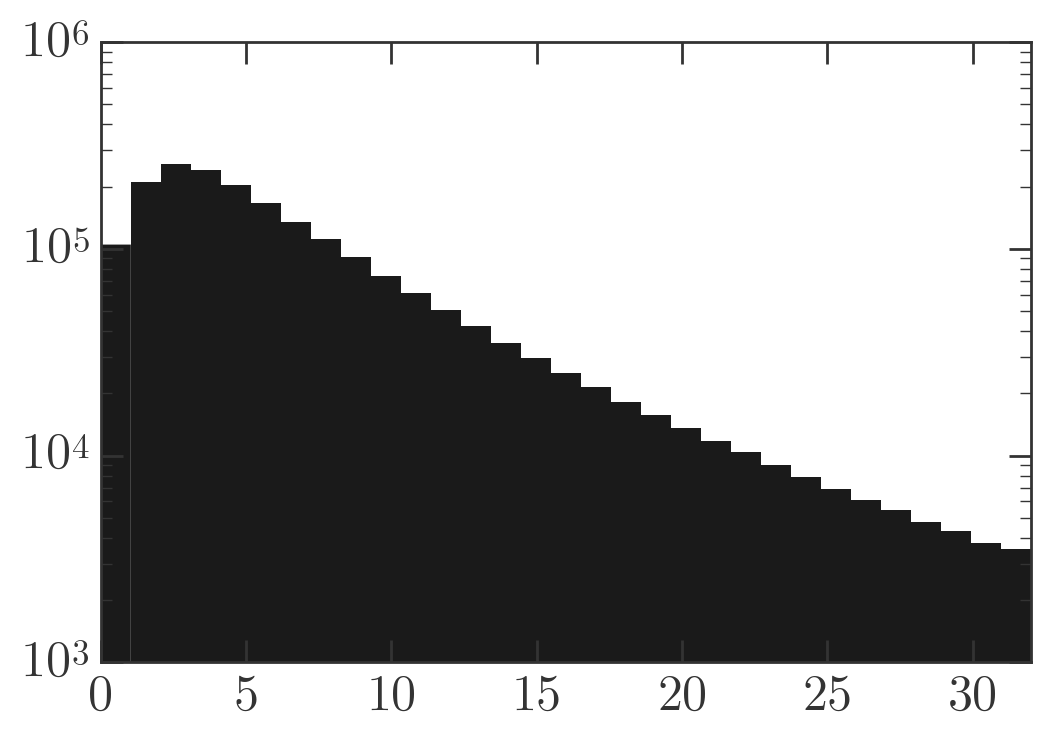

In [5]:
plt.hist(tgas.parallax_snr, bins=np.linspace(0, 32, 32));
plt.yscale('log')
plt.xlim(0, 32)

(1, 1000000.0)

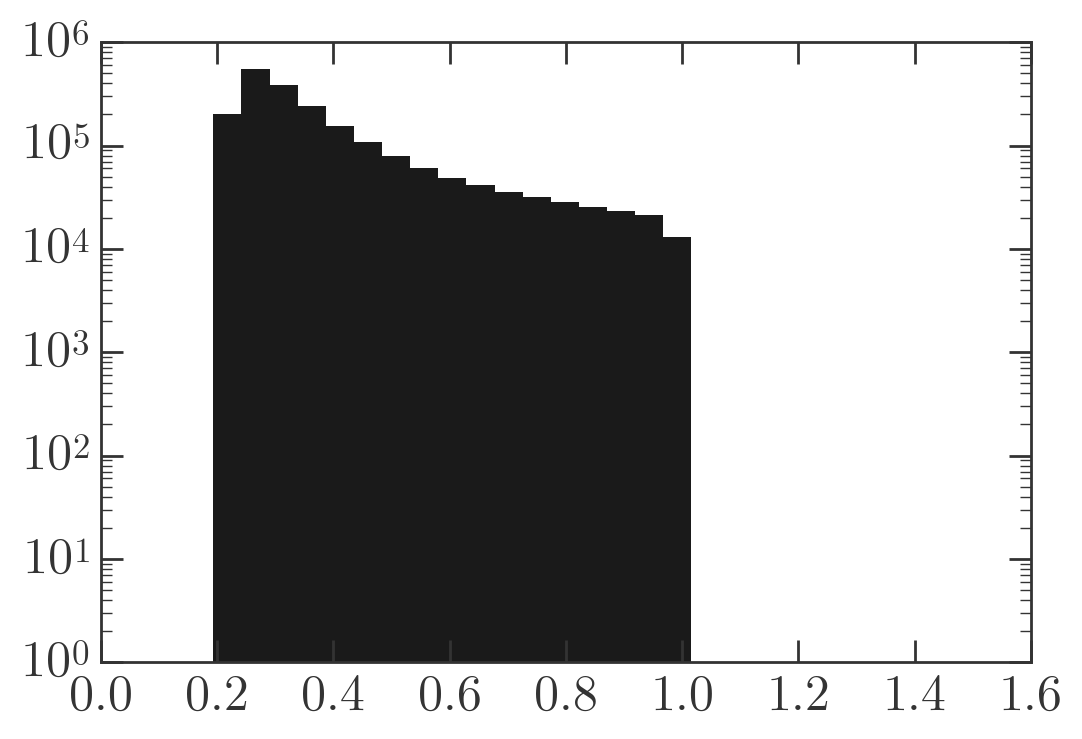

In [6]:
plt.hist(tgas.parallax_error.value, bins=np.linspace(0, 1.5, 32));
plt.yscale('log')
# plt.xlim(0, 32)
plt.ylim(1,1E6)

In [7]:
np.median(tgas.parallax_error)

<Quantity 0.3220123599925623 marcsec>

## Figure 1

In [92]:
tgas_snr = tgas[tgas.parallax_snr >= 32]

In [93]:
c = tgas_snr.get_coord()
X = c.cartesian.xyz.T

In [94]:
tree = KDTree(X)
tree_d,tree_i = tree.query(X, k=2) # 0th match is always self
tree_d = tree_d[:,1:]
tree_i = tree_i[:,1:]

In [95]:
all_sep = tree_d.ravel()

In [96]:
idx0 = np.arange(len(tgas_snr), dtype=int)
idx0 = np.repeat(idx0[:,None], 1, axis=1)
all_pair_idx = np.vstack((idx0.ravel(), tree_i.ravel())).T

# now compute velocity difference
vtan = tgas_snr.get_vtan().to(u.km/u.s).value
all_dv = np.sqrt(np.sum((vtan[all_pair_idx[:,0]] - vtan[all_pair_idx[:,1]])**2, axis=1))

In [97]:
all_sep.shape, all_dv.shape

((42385,), (42385,))

In [98]:
all_pair_idx = np.sort(all_pair_idx, axis=1)
str_pairs = np.array(["{}{}".format(i,j) for i,j in all_pair_idx])
_, unq_idx = np.unique(str_pairs, return_index=True)
all_pair_idx = all_pair_idx[unq_idx]

dv = all_dv[unq_idx]
sep = all_sep[unq_idx]

In [99]:
sep.shape, dv.shape

((29870,), (29870,))

In [100]:
a = np.logspace(0, 6, 1024) * u.au
v = np.sqrt(G*2*M_sun / a).to(u.km/u.s)

In [ ]:
# with mpl.rc_context(rc={'text.usetex': True, 'text.latex.preamble': r"\usepackage{amsmath}"}):
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.semilogx(sep, dv, linestyle='none', alpha=0.5, markersize=3, rasterized=True, zorder=-10)

# ax.plot(a.to(u.pc).value, v, marker='', alpha=0.75,
#         ls='-', color='#43a2ca', zorder=-100, linewidth=1)
ax.axhline(0, ls='--', color='#43a2ca', zorder=-100, linewidth=1, alpha=0.75)

ax.set_xlim(1E-3, 5)
ax.set_ylim(-1, 26)

ax.set_xlabel(r'$|\Delta x|$ [pc]')
ax.set_ylabel(r'$|\Delta v_{\rm t}|$ [km s$^{-1}$]')

ax.yaxis.set_ticks(range(0,25+1,5))

ax.set_title(r"{} pairs with [S/N]$_{{\varpi/\sigma_\varpi}} > 32$".format(len(sep)), 
             fontsize=20, verticalalignment='bottom')
fig.tight_layout()

fig.savefig("../paper/figures/dv-sep.pdf", dpi=300)

# Figure 2

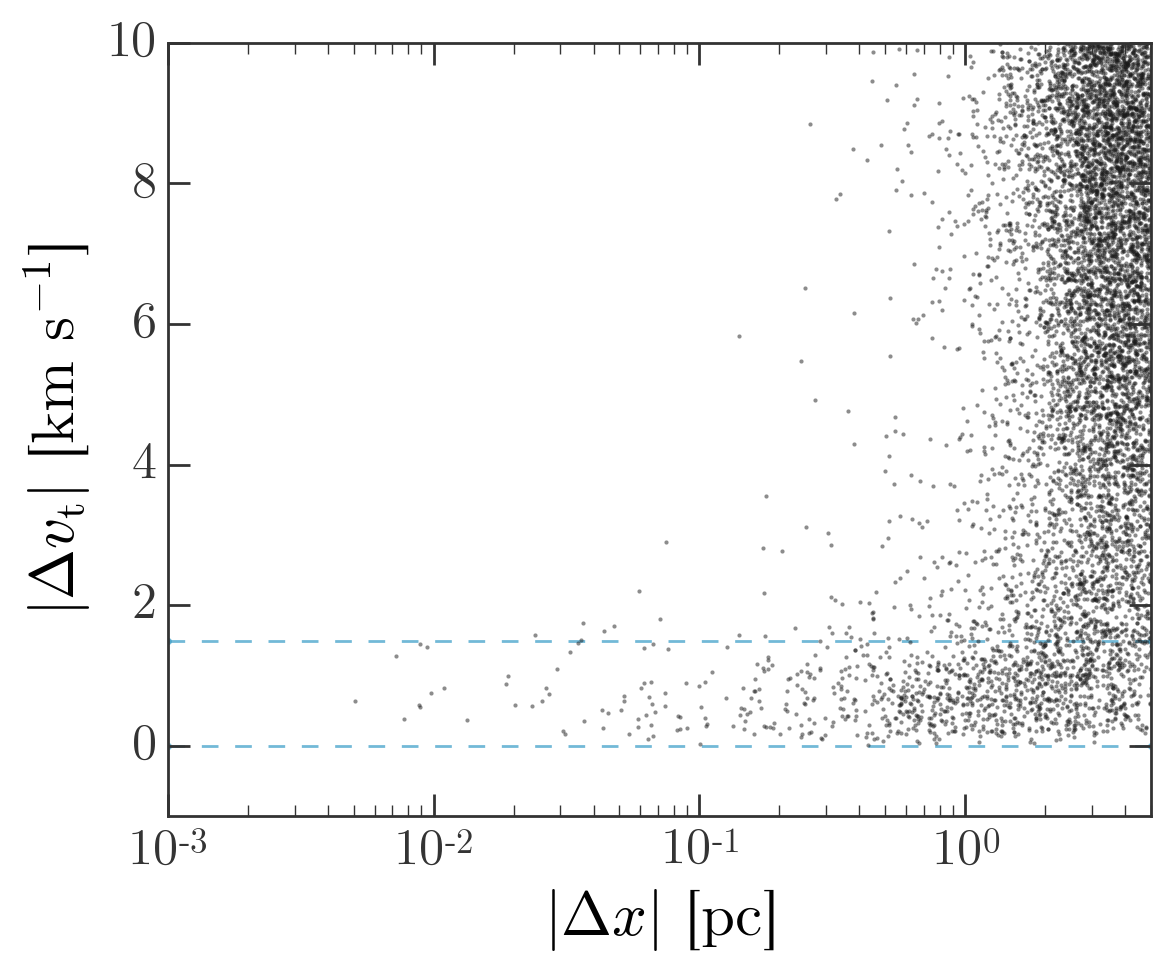

In [51]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.semilogx(sep, dv, linestyle='none', alpha=0.5, markersize=3, rasterized=True, zorder=-10)

ax.axhline(0, ls='--', color='#43a2ca', zorder=-100, linewidth=1, alpha=0.75)
ax.axhline(1.5, ls='--', color='#43a2ca', zorder=-100, linewidth=1, alpha=0.75)

ax.set_xlim(1E-3, 5)
ax.set_ylim(-1, 10)

ax.set_xlabel(r'$|\Delta x|$ [pc]')
ax.set_ylabel(r'$|\Delta v_{\rm t}|$ [km s$^{-1}$]')
fig.tight_layout()

In [53]:
dv_cut = dv < 1.5
all_pair_idx[dv_cut].shape

(1212, 2)

In [54]:
tgas1 = tgas_snr[all_pair_idx[dv_cut,0]]
tgas2 = tgas_snr[all_pair_idx[dv_cut,1]]

In [59]:
all_c1 = tgas1.get_coord()
all_c2 = tgas2.get_coord()

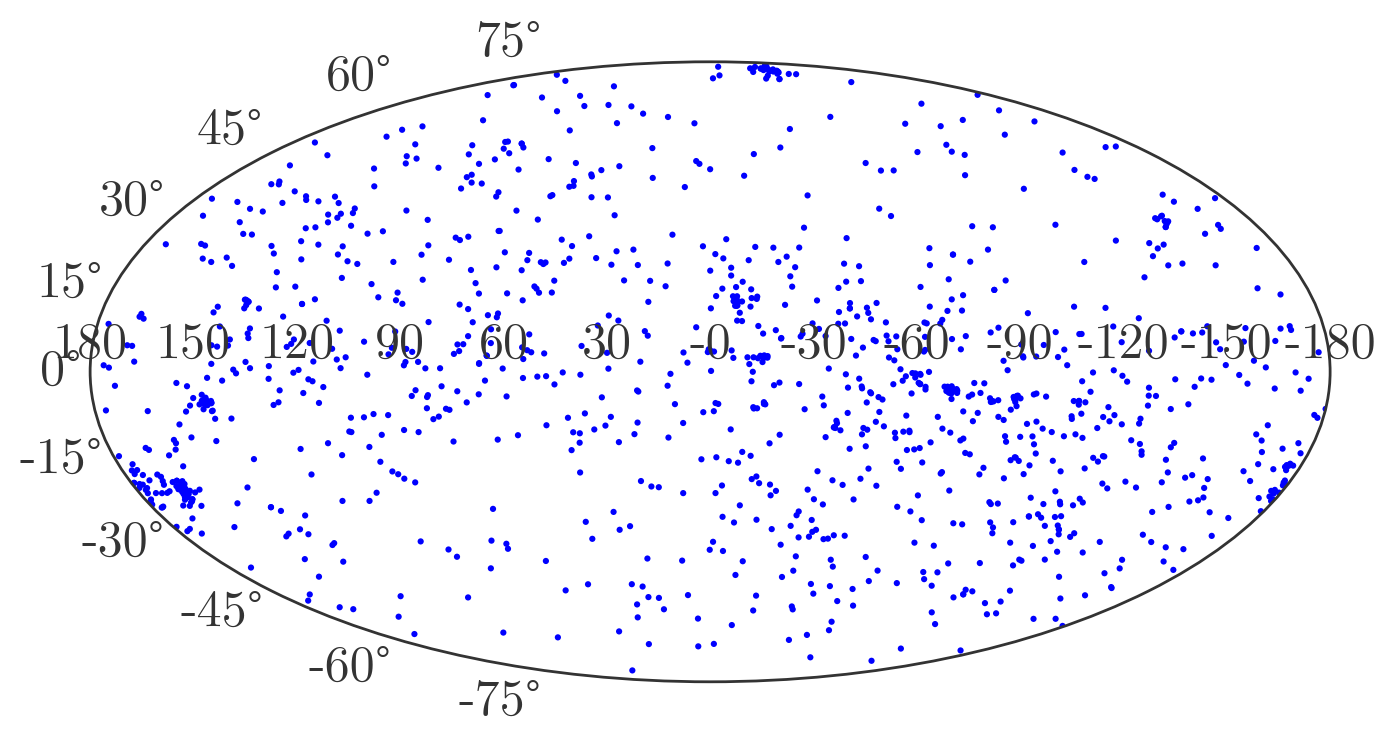

In [91]:
fig,ax = plt.subplots(1,1,figsize=(8,6),subplot_kw=dict(projection='aitoff'))

l = all_c1.galactic.l.wrap_at(180*u.degree)
mod_l = coord.Angle(-l)
b = all_c1.galactic.b

ax.scatter(mod_l.radian, b.radian, marker='.')

# OMG this is so horrifying
ax.set_xticks(np.arange(-np.pi, np.pi+1E-3, np.pi/6))
ax.xaxis.set_ticklabels(["{:.0f}".format(round(x)) for x in np.degrees(ax.get_xticks()[::-1])]);

# plt.xlim(360, 0)
# plt.ylim(-60, 60)